In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, TimeDistributed, Concatenate
import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Using TensorFlow backend.


In [16]:
def convert_to_padded_seqs(df):
    seqs = []
    subseq = []
    for ix, row in df.iterrows():
        if row['seq'] == 1 and subseq != []:
            seqs.append(subseq)
            subseq = []
        row = row.drop('seq')
        subseq.append(list(row.values))
    sequences = pad_sequences(seqs, padding='post', dtype='float64')
    return sequences

In [17]:
def fix_angle(angle):
    if angle > 180.0:
        return 360.0 - angle 
    elif angle == 0:
        return 0.0
    else:
        return -angle

In [18]:
# Convert to a DataFrame and render.
import pandas as pd
df = pd.read_csv('app/data-capture-2-7-940.csv')
df.drop(['NOTES:', 'Unnamed: 11', 'Unnamed: 12', 'alignment'], axis=1, inplace=True)
df = df.rename(columns={
      "xxz": "seq",
      "x (out of 300)": "x",
      "y (out of 400)": "y",
      "# of characters": "chars",
      "font size": "font_size",
      "# of words": 'words',
      "lines of text": 'lines',
      "caps or lowercase": 'caps'
    })
df['weight'] = df['font weight'].apply(lambda x: x.split(' ')[-1])
df['condensed'] = df['font weight'].str.contains('condensed').astype(int)
df.drop('font weight', axis=1, inplace=True)
df = df.replace(
    {'weight':{
        'light': 0,
        'regular': 1,
        'medium': 2,
        'bold': 3
     },
     'caps': {
         'C': 1,
         'L': 0
     }
})
continuous_vars = ['seq','x', 'y', 'rotation', 'font_size', 'chars', 'lines']
df.rotation = df.rotation.apply(fix_angle)
df = df[continuous_vars]

In [180]:
def scale_df_minmax(df):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df.iloc[:,1:])
    return pd.concat([df.iloc[:,0], pd.DataFrame(scaled)], axis=1), scaler

In [181]:
scaled, scaler = scale_df_minmax(df)
keras_ready = convert_to_padded_seqs(scaled)

In [190]:
inp = keras.Input((None, 6))
rnn = LSTM(16, activation='tanh', dropout=.5, return_sequences=True)(inp)
dense = TimeDistributed(Dense(6, activation='linear'))(rnn)
model = keras.models.Model(input=inp, output=dense)
model.compile(loss='mean_squared_error',
              optimizer='adam')

/Users/brian/.virtualenvs/typeforce/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`
  after removing the cwd from sys.path.


In [191]:
X = keras_ready[:,:-1,:]
Y = keras_ready[:,1:,:]
h = model.fit(x=X, y=Y, batch_size=1, epochs=18)

Epoch 1/18
14/14 [==============================] - 2s 149ms/step - loss: 0.6229
Epoch 2/18
14/14 [==============================] - 0s 13ms/step - loss: 0.6023
Epoch 3/18
14/14 [==============================] - 0s 13ms/step - loss: 0.6090
Epoch 4/18
14/14 [==============================] - 0s 13ms/step - loss: 0.5921
Epoch 5/18
14/14 [==============================] - 0s 13ms/step - loss: 0.5906
Epoch 6/18
14/14 [==============================] - 0s 14ms/step - loss: 0.5866
Epoch 7/18
14/14 [==============================] - 0s 15ms/step - loss: 0.5693
Epoch 8/18
14/14 [==============================] - 0s 14ms/step - loss: 0.5577
Epoch 9/18
14/14 [==============================] - 0s 14ms/step - loss: 0.5627
Epoch 10/18
14/14 [==============================] - 0s 14ms/step - loss: 0.5525
Epoch 11/18
14/14 [==============================] - 0s 14ms/step - loss: 0.5430
Epoch 12/18
14/14 [==============================] - 0s 14ms/step - loss: 0.5552
Epoch 13/18
14/14 [=================

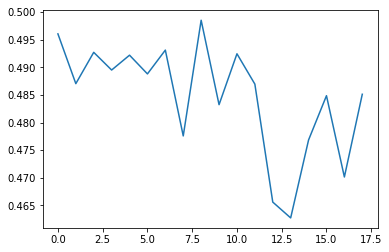

In [189]:
pd.Series(h.history['loss']).plot()

In [192]:
def get_seq_from_model(input_feats):
    seq = []
    for thing in input_feats:
        print(thing)
        prediction = model.predict(np.reshape(scaler.transform([thing]), (1,1,6)))
        seq.append(prediction)
    return np.squeeze(np.concatenate(seq))

results = get_seq_from_model(convert_to_padded_seqs(df)[0])

[11.   26.   -8.   16.25 15.    1.  ]
[142.    11.    -8.    11.64   9.     1.  ]
[ 17.    86.   -23.69  49.74   4.     1.  ]
[ 12.   135.   -12.58  73.67   9.     1.  ]
[ 15.   194.    -2.11  16.25  11.     1.  ]
[141.   190.    -2.11  16.25  12.     1.  ]
[ 53.   210.    34.66  39.42   6.     1.  ]
[142.   280.    34.66  27.46   6.     1.  ]
[184.   318.    34.66  18.56   6.     1.  ]
[228.   353.    34.66  11.46   6.     1.  ]
[ 73.   327.   -48.42  13.    22.     1.  ]
[ 43.   321.    29.45  10.    29.     2.  ]
[ 20.   344.    29.45   7.36  30.     2.  ]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]


In [193]:
res = pd.DataFrame(scaler.inverse_transform(results), columns=df.columns[1:])

In [195]:
res

,x,y,rotation,font_size,chars,lines
0,101.860924,186.658264,0.831418,27.349586,21.650560,1.344181
1,109.895912,201.903320,-2.405199,23.987993,24.571165,1.351018
2,103.876205,191.602982,-0.757947,29.212898,22.053806,1.346501
3,103.168419,193.983765,-1.679997,30.160410,22.439985,1.340491
4,105.328506,193.663956,-1.733243,28.356825,21.025604,1.353309
5,111.354683,206.577927,-3.933034,24.459982,22.907776,1.354287
6,105.401566,198.432968,-3.794040,28.022846,22.466911,1.333287
7,110.817856,209.890381,-5.846337,24.978666,22.240440,1.336953
8,112.498993,212.934540,-6.161623,23.064922,21.547766,1.338602
9,113.414146,214.676987,-6.187781,21.145607,20.811314,1.336543


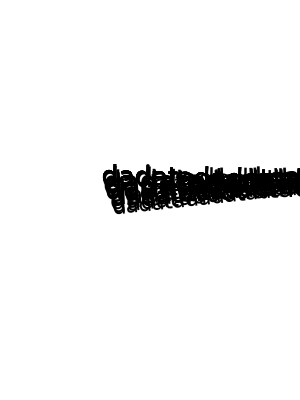

In [194]:
SVG(draw_poster(res))

In [96]:
for thing in convert_to_padded_seqs(df)[0]:
    print()

[[0.04135338 0.05026455 0.52347383 0.06220572 0.08187135 0.        ]]
[[0.53383459 0.01058201 0.52347383 0.04133466 0.04678363 0.        ]]
[[0.06390977 0.20899471 0.46556433 0.21382651 0.01754386 0.        ]]
[[0.04511278 0.33862434 0.50656972 0.32216588 0.04678363 0.        ]]
[[0.05639098 0.49470899 0.54521296 0.06220572 0.05847953 0.        ]]
[[0.53007519 0.48412698 0.54521296 0.06220572 0.06432749 0.        ]]
[[0.19924812 0.53703704 0.68092567 0.16710431 0.02923977 0.        ]]
[[0.53383459 0.72222222 0.68092567 0.11295726 0.02923977 0.        ]]
[[0.69172932 0.82275132 0.68092567 0.07266389 0.02923977 0.        ]]
[[0.85714286 0.91534392 0.68092567 0.04051974 0.02923977 0.        ]]
[[0.27443609 0.84656085 0.37428951 0.04749185 0.12280702 0.        ]]
[[0.16165414 0.83068783 0.66169632 0.03390982 0.16374269 0.1       ]]
[[0.07518797 0.89153439 0.66169632 0.02195762 0.16959064 0.1       ]]
[[ 0.         -0.01851852  0.55300066 -0.01136364 -0.00584795 -0.1       ]]
[[ 0.         

In [44]:
from IPython.display import SVG
import xml.etree.ElementTree as ET
import math

def dadata(length):
    return ("dadata" * math.ceil(length/6))[:length]

def draw_poster(data):
    svg = ET.Element('svg', xmlns="http://www.w3.org/2000/svg", version="1.1",
                     height="400", width="300")
    txt_settings = {
        "text_anchor":"start",
        "font-family":"Helvetica Neue",
        
    }
    for ix, row in data.iterrows():
        text = ET.SubElement(svg,"text", 
                             x=str(row.x), y=str(row.y),
                             transform="rotate({} {} {})".format(row.rotation, row.x, row.y),
                             #TODO: WEIGHT
                            )
        text.set('font-size', str(row.font_size))
        text.text=dadata(int(row.chars))
    return ET.tostring(svg)

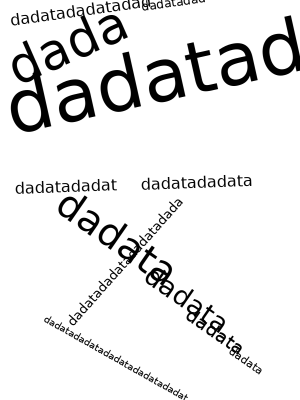

In [162]:
SVG(draw_poster(df[:12]))

In [ ]:
df. 